PERDICT THE LABEL OF A PROGRAMMING QUESTION IN STACK OVERFLOW

Amacımız stack overflow da sorulan soruların hangi kodlama diliyle alakalı olduğunu bulmak

In [1]:
# 1-IMPORTING LIBRARIES

import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:

url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                   untar=True, cache_dir='.',
                                    cache_subdir='')


6053168/6053168 [==============================] - 0s 0us/step


In [3]:
train_dir = os.path.join("/content/train")
os.listdir(train_dir)

['python', 'javascript', 'csharp', 'java']

In [4]:
test_dir= os.path.join("/content/test")
os.listdir(test_dir)

['python', 'javascript', 'csharp', 'java']

In [5]:
# Örnek bir cümleye bakalım
sample_file = os.path.join(train_dir,"/content/train/python/10.txt")
with open(sample_file) as f:
  print(f.read())

"how to read instance variables from another file without instantiating the class? i'm relatively new to blank and i'm having some trouble importing a variable to use it in another class. i did look at several other questions on this topic and tried to make it work, but it seems the way i set up this program early on might be the problem. i'll simplify what's going on so there's less to read.....server.py:..import game.class server():.    def __init__(self):.        # server connection details here.        self.test = 5.        self.game = game()..    def serve(self):.        # client processing, etc..        self.game.game_loop()..if __name__ == ""__main__"":.    server = server().    server.serve()...game.py:..class game():.    def __init__(self):.        # other variables.....    def game_loop(self):.        # to reference server's instance variables.        from server import server..        print test...in this example, i'm trying to reference the variable ""test"" from the server

VERİ KÜMESİNİ YÜKLEYİP TANIMLAYALIM

In [6]:
# train ve validation setlerini belirleyelim
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    "/content/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "training",
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [7]:
# Örnek olarak bir bakalım
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question",text_batch.numpy()[i])
    print("Label",label_batch.numpy()[i])

Question b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default const

In [8]:
print("Label 0 corresponds to",raw_train_ds.class_names[0])
print("Label 1 corresponds to",raw_train_ds.class_names[1])
print("Label 2 corresponds to",raw_train_ds.class_names[2])
print("Label 3 corresponds to",raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [9]:
# Validation setini tanımlayalım
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    "/content/train",
    batch_size = batch_size,
    validation_split = 0.2,
    subset = "validation",
    seed = seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
# Test Veri setini tanımlayalım
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    "/content/test",
    batch_size = batch_size
)

Found 8000 files belonging to 4 classes.


PREPROCESSİNG


In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data) # harfleri küçültelim
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ') # html etiketlerini temizliyoruz
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [12]:
# Standardization and Vectorization işlemlerini uygulayalım
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = "int",
    output_sequence_length = sequence_length
)

In [13]:
# Vectorize katmanını oluşturduk şimdi metinlere uygulamadan önce veri setindeki cümle ve labelları birbirinden ayırmamız lazım
train_text = raw_train_ds.map(lambda x , y : x)
# vectorize_layer ı veri setine uydurmak için adapt fonksiyonu çağırıyoruz
# Not : adapt sadece train veri setine uygulanır
vectorize_layer.adapt(train_text)

In [14]:
# örnek görmek için fonksiyon hazırlayalım
def vectorize_text(text,label):
  text = tf.expand_dims(text,-1)
  return vectorize_layer(text),label

In [15]:
# veri setinden bir batch yani 32 örnek alalım
text_batch,label_batch = next(iter(raw_train_ds))
first_question , first_label = text_batch[0],label_batch[0]
print("First Question" , first_question)
print("Label" , first_label)
print("Vectorize Question" , vectorize_text(first_question,first_label))

First Question tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple

In [16]:
# vectorize edilmiş bazı kelimelere bakalım
print("159------->" , vectorize_layer.get_vocabulary()[159])
print("2------->",vectorize_layer.get_vocabulary()[2])
print("1 ----------->" , vectorize_layer.get_vocabulary()[1])
print("Toplam vectorize edilmiş kelime sayısı-->{}".format(len(vectorize_layer.get_vocabulary()))  )


159-------> question
2-------> the
1 -----------> [UNK]
Toplam vectorize edilmiş kelime sayısı-->10000


In [18]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

önbellek ve prefectch işlemleri

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)


MODEL OLUŞTURMA

In [22]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features+1,embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160084 (625.33 KB)
Trainable params: 160084 (625.33 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [24]:
# model compile
model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = "adam",
              metrics = ["accuracy"]
              )

In [26]:
# modeli eğitelim
epochs = 20
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/20
200/200 [==============================] - 1s 7ms/step - loss: 0.7657 - accuracy: 0.7858 - val_loss: 0.7769 - val_accuracy: 0.7744
Epoch 2/20
200/200 [==============================] - 1s 7ms/step - loss: 0.7257 - accuracy: 0.7998 - val_loss: 0.7451 - val_accuracy: 0.7850
Epoch 3/20
200/200 [==============================] - 1s 7ms/step - loss: 0.6899 - accuracy: 0.8053 - val_loss: 0.7173 - val_accuracy: 0.7887
Epoch 4/20
200/200 [==============================] - 2s 11ms/step - loss: 0.6575 - accuracy: 0.8159 - val_loss: 0.6921 - val_accuracy: 0.7944
Epoch 5/20
200/200 [==============================] - 2s 10ms/step - loss: 0.6281 - accuracy: 0.8277 - val_loss: 0.6706 - val_accuracy: 0.7937
Epoch 6/20
200/200 [==============================] - 1s 7ms/step - loss: 0.6016 - accuracy: 0.8313 - val_loss: 0.6509 - val_accuracy: 0.7969
Epoch 7/20
200/200 [==============================] - 1s 7ms/step - loss: 0.5772 - accuracy: 0.8392 - val_loss: 0.6323 - val_accuracy: 0.7962
Epoc

In [27]:
loss , accuracy = model.evaluate(test_ds)
print("Loss" , loss)
print("Accuracy" ,accuracy)

250/250 [==============================] - 2s 5ms/step - loss: 0.5592 - accuracy: 0.7970
Loss 0.5591713190078735
Accuracy 0.796999990940094


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

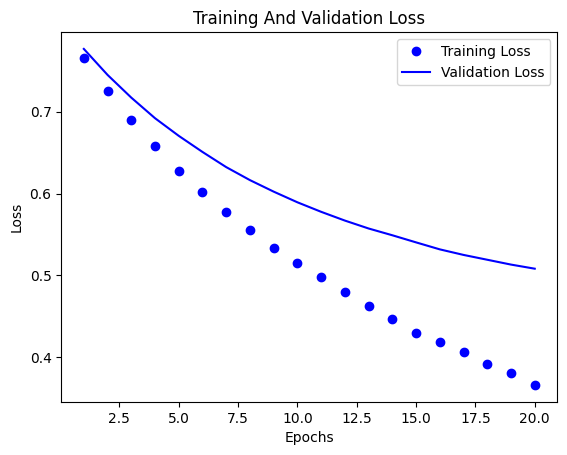

In [29]:
# Doğruluk ve kayıp grafiklerini oluşturalım
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(acc)+1)

plt.plot(epochs,loss,"bo",label = "Training Loss")
plt.plot(epochs,val_loss,"b",label = "Validation Loss")
plt.title("Training And Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

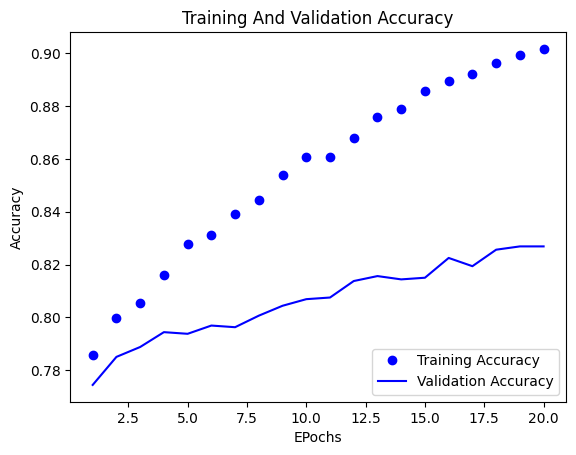

In [31]:
plt.plot(epochs,acc,"bo",label = "Training Accuracy")
plt.plot(epochs,val_acc,"b",label = "Validation Accuracy")
plt.title("Training And Validation Accuracy")
plt.xlabel("EPochs")
plt.ylabel("Accuracy")
plt.legend(loc = "lower right")
plt.show()

In [32]:
# modeli dışa aktaralım
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation("sigmoid")
])

export_model.compile(loss = losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer = "adam",
                     metrics = ["accuracy"])

In [34]:
loss , accuracy =  export_model.evaluate(raw_test_ds)
print("Accuracy:",accuracy)
print("loss : " , loss)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


250/250 [==============================] - 4s 9ms/step - loss: 0.5592 - accuracy: 0.7970
Accuracy: 0.796999990940094
loss :  0.5591710805892944


In [40]:
examples = ["Return the maximum length of a substring of s that can be changed to be the same as the corresponding substring of t with a cost less than or equal to maxCost. If there is no substring from s that can be changed to its corresponding substring from t, return 0.",
            "I want to combine this dataframe with itself then, get the total length for orders, the length of unique values for columns, and the list of unique values for customers. Then, I want to sort in descending for the orders length and ascending for the columns length. But I should also keep the original version of the combination. For this situation, I did the following",
            "If we can assume that each process describes a set of orders made by a single customer on a single column, then we can replace associated lists with their single representatives. And the question of expected column_length and customers values can be replaced by whether or not columns and customers associated with a pair of processes are equal, sort of:"]

export_model.predict(examples)


1/1 [==============================] - 0s 36ms/step


array([[0.4314122 , 0.5922919 , 0.3585906 , 0.6046086 ],
       [0.35375997, 0.43074888, 0.34450713, 0.8262189 ],
       [0.6166501 , 0.47747067, 0.39206558, 0.4919412 ]], dtype=float32)

['python', 'javascript', 'csharp', 'java']
